### install dependencies

In [1]:
#!pip install -U sagemaker

### import libraries

In [2]:
import sagemaker
import pandas as pd
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
import boto3
from sagemaker.serializers import CSVSerializer
from io import StringIO
import numpy as np
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Make model

In [3]:
data_location = 's3://testbucketforcreditproject/train_data.csv'
sagemaker_session = sagemaker.Session()
role = get_execution_role()
container = sagemaker.image_uris.retrieve("xgboost", version='0.90-1', region=sagemaker_session.boto_region_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
xgboost = Estimator(container,
                    role,
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    output_path='s3://testbucketforcreditproject/output/',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={'objective': 'binary:logistic',
                                     'num_round': 100})

### Train Model

In [5]:
xgboost.fit({'train': TrainingInput(data_location, content_type='text/csv')})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-12-03-19-41-20-441


2023-12-03 19:41:20 Starting - Starting the training job...
2023-12-03 19:41:45 Starting - Preparing the instances for training.........
2023-12-03 19:43:14 Downloading - Downloading input data...
2023-12-03 19:43:44 Training - Downloading the training image...
2023-12-03 19:44:15 Training - Training image download completed. Training in progress....
2023-12-03 19:44:52 Uploading - Uploading generated training model
2023-12-03 19:44:52 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:44:31] 24001x30 matrix with 720030 entries loaded fro

### Create predictor and test

In [6]:
predictor = xgboost.deploy(
    instance_type='ml.m4.xlarge',
    initial_instance_count=1,
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-12-03-19-45-10-264
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-12-03-19-45-10-264
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-12-03-19-45-10-264


------!

In [9]:
aws_access_key_id = ''
aws_secret_access_key = ''
s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

In [13]:
bucket_name = 'testbucketforcreditproject'
file_key = 'test_data.csv'
s3_response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
csv_content = s3_response['Body'].read().decode('utf-8')
test_data = pd.read_csv(StringIO(csv_content))

### Load Data

In [14]:
predict_data = test_data.drop('default payment next month', axis=1)

### Calculate accuracy

In [15]:
predictions = predictor.predict(predict_data.values).decode('utf-8')
predictions = [float(prediction) for prediction in predictions.split(',')]
actual_labels = test_data.iloc[:, 0].values
predicted_labels = [1 if prediction > 0.5 else 0 for prediction in predictions]
accuracy = sum(actual_labels == predicted_labels) / len(actual_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 81.23%


In [16]:
# MSE
true_labels = test_data.iloc[:, 0].values
squared_errors = (predictions - true_labels) ** 2
mse = np.mean(squared_errors)
print(f'Mean Squared Error (MSE): {mse:.4f}')

Mean Squared Error (MSE): 0.1412


In [17]:
# Precision
binary_predictions = [1 if prediction > 0.5 else 0 for prediction in predictions]
precision = precision_score(true_labels, binary_predictions)
print(f'Precision: {precision:.4f}')

Precision: 0.6596


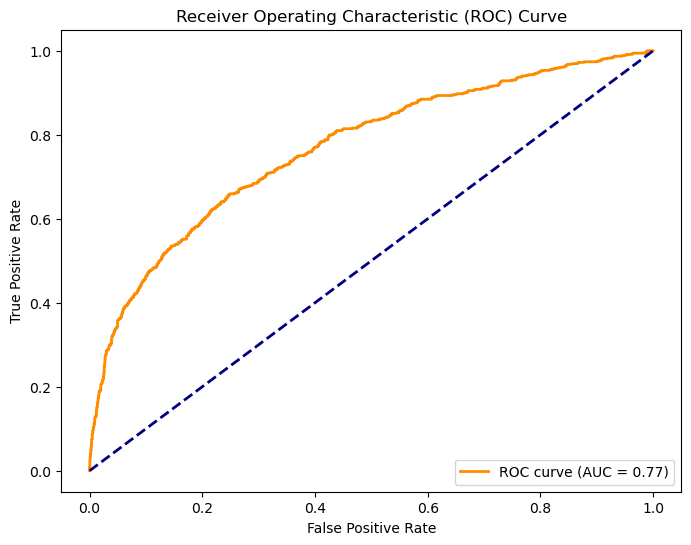

In [18]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Close predictor

In [27]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-12-02-23-01-24-551
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-12-02-23-01-24-551
